# Catboost predictor - Frequency encoded
Implemented version of the catboost model predictor model with one-hot encoding

In [11]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [12]:
#import the data
#if it drops a memory problem: increase the pagefile size on your computer!
X_train = pd.read_csv("data/generated/frequency/X_train.csv")
y_train = pd.read_csv("data/generated/frequency/y_train.csv")
X_test = pd.read_csv("data/generated/frequency/X_test.csv")
y_test = pd.read_csv("data/generated/frequency/y_test.csv")
X_test.head(3)

,Unnamed: 0,EventID,time:timestamp,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,Selected,CreditScore,...,EventOrigin_Workflow,lifecycle:transition_ate_abort,lifecycle:transition_complete,lifecycle:transition_resume,lifecycle:transition_schedule,lifecycle:transition_start,lifecycle:transition_suspend,lifecycle:transition_withdraw,case:ApplicationType_Limit raise,case:ApplicationType_New credit
0,1093289,Application_1000386745,2016-11-25 14:31:09.852000+00:00,Application_1000386745,5000.0,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,1
1,1093290,ApplState_508603983,2016-11-25 14:31:11.088000+00:00,Application_1000386745,5000.0,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,1
2,1093291,Workitem_1662375286,2016-11-25 14:31:11.309000+00:00,Application_1000386745,5000.0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,1


### Pre-process the data

In [13]:
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

In [14]:
missing_columns = set(X_train.columns) - set(X_test.columns)
print("Missing columns:", missing_columns)

Missing columns: set()


In [15]:
columns_2_drop= ['Unnamed: 0', 'EventID',
        'time:timestamp',
       'case:concept:name', 'Selected']

In [16]:
# Drop the unnamed and lifecycle columns column
X_test = X_test.drop(columns_2_drop, axis=1)
X_train = X_train.drop(columns_2_drop + list(missing_columns), axis=1)

In [17]:
X_test.head()

,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount,event_index_in_trace,execution_time,Action_Created,Action_Deleted,...,EventOrigin_Workflow,lifecycle:transition_ate_abort,lifecycle:transition_complete,lifecycle:transition_resume,lifecycle:transition_schedule,lifecycle:transition_start,lifecycle:transition_suspend,lifecycle:transition_withdraw,case:ApplicationType_Limit raise,case:ApplicationType_New credit
0,5000.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,1,0,...,0,0,1,0,0,0,0,0,0,1
1,5000.0,NaN,NaN,NaN,NaN,NaN,1,0.000014,1,0,...,0,0,1,0,0,0,0,0,0,1
2,5000.0,NaN,NaN,NaN,NaN,NaN,2,0.000017,2,0,...,1,0,0,0,1,0,0,0,0,1
3,5000.0,NaN,NaN,NaN,NaN,NaN,3,0.001048,2,1,...,1,0,0,0,0,0,0,1,0,1
4,5000.0,NaN,NaN,NaN,NaN,NaN,4,0.001048,3,1,...,1,0,0,0,1,0,0,0,0,1


In [18]:
X_test.dtypes

case:RequestedAmount                float64
FirstWithdrawalAmount               float64
NumberOfTerms                       float64
MonthlyCost                         float64
CreditScore                         float64
                                     ...   
lifecycle:transition_start            int64
lifecycle:transition_suspend          int64
lifecycle:transition_withdraw         int64
case:ApplicationType_Limit raise      int64
case:ApplicationType_New credit       int64
Length: 214, dtype: object

### Building the model

In [19]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [20]:
# Train the model
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=10, verbose=10)

0:	learn: 13.4747622	test: 11.9212112	best: 11.9212112 (0)	total: 240ms	remaining: 1m 59s
10:	learn: 13.0538793	test: 11.4867527	best: 11.4867527 (10)	total: 1.04s	remaining: 46.1s
20:	learn: 12.6982711	test: 11.1210723	best: 11.1210723 (20)	total: 1.87s	remaining: 42.7s
30:	learn: 12.3993236	test: 10.8143504	best: 10.8143504 (30)	total: 2.67s	remaining: 40.4s
40:	learn: 12.1476975	test: 10.5589832	best: 10.5589832 (40)	total: 3.48s	remaining: 38.9s
50:	learn: 11.9369396	test: 10.3506279	best: 10.3506279 (50)	total: 4.28s	remaining: 37.7s
60:	learn: 11.7613149	test: 10.1734008	best: 10.1734008 (60)	total: 5.08s	remaining: 36.5s
70:	learn: 11.6135132	test: 10.0281306	best: 10.0281306 (70)	total: 5.87s	remaining: 35.5s
80:	learn: 11.4906383	test: 9.9073777	best: 9.9073777 (80)	total: 6.66s	remaining: 34.5s
90:	learn: 11.3865775	test: 9.8087142	best: 9.8087142 (90)	total: 7.46s	remaining: 33.6s
100:	learn: 11.3000542	test: 9.7270070	best: 9.7270070 (100)	total: 8.26s	remaining: 32.6s
110:

In [21]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [22]:
# MSE
mean_squared_error(y_test, y_pred)

87.24382937519675

In [23]:
# R2
r2_score(y_test, y_pred)

0.38782555577053657

### Feature importance

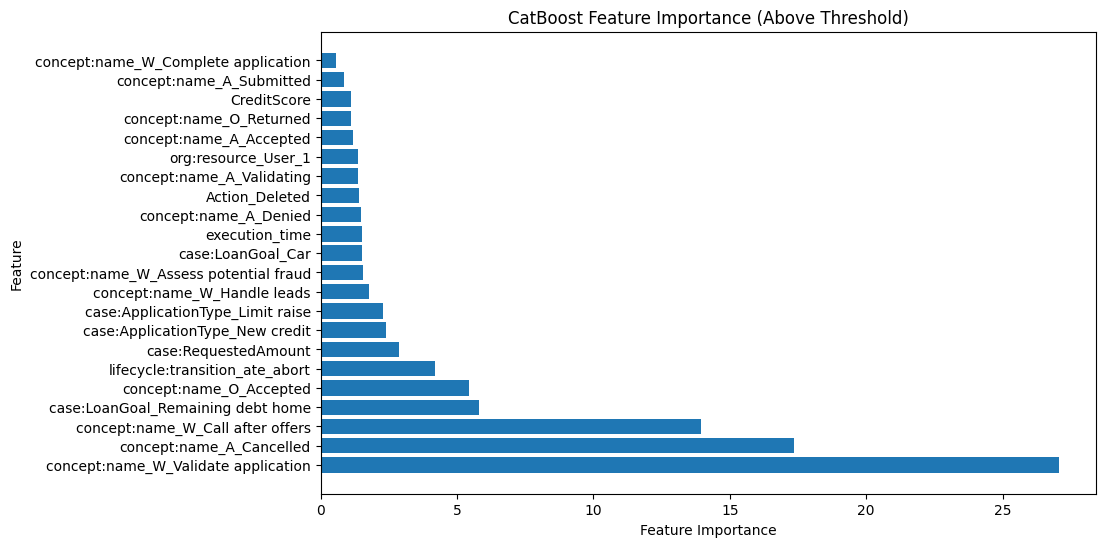

In [27]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.5  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()
